# Local likelihood optimization

In the previous notebook, we went through the calculation of the likelihood function for an HMM and explicitly minimized it. Specifically, we looked at a situation where the transition rate and emission probability matrices took the form

$$ \boldsymbol{A} = \left[ \begin{matrix} 1 - a & a \\ a & 1 - a \end{matrix} \right] $$

and 

$$ \boldsymbol{B} = \left[ \begin{matrix} 1 - b & b \\ b & 1 - b \end{matrix} \right] $$

respectively, then we estimated the parameters $a$ and $b$ given an observed sequence of states.

*A priori* we will not know what the hidden state sequence was (it is hidden, after all...) So, to deal with this we would need to calculate the likelihood over all possible hidden state sequences, and all parameter values in the $A$ and $B$ matrices. This problem will quickly become very high dimensional, and as a result we must resort to other methods. Specifically, we can perform a local optimization routine on the parameter space, for a given initial starting point.

In this notebook, we will first build a custom gradient descent algorithm to track the evolution of the parameter vector over iterations, and then use these results to validate a more efficient implementation using a `scipy.optimize.minimize` function to do the heavy lifting.

#### Gradient descent

Given that we are trying to minimize the likelihood function $\mathcal{L}(\theta)$, for parameter vector $\theta$, the general form of a gradient descent algorithm will update the value of the parameter vector $\theta_i \to \theta_{i+1}$ as

$$ \theta_{i+1} = \theta_i - \eta \nabla \mathcal{L}(\theta_i) $$

where $\nabla$ is the gradient of the likelihood function and $\eta$ is the *learning rate* which determines how large the update steps are. For an initial implementation, we take the learning rate to be constant, but there are many schemes that optimize this parameter by dynamically updating it so that the solution converges towards a local minimum more rapidly.  In order to calculate the derivative of the likelhood function, we will use a simple first-order difference in the likelihood function, approximating each component of the gradient with a simple first-difference

$$ \partial_{\theta^k}\mathcal{L}(\theta_i) \approx \frac{1}{2 \Delta\theta^{k}} \left[ \mathcal{L}(\theta + \Delta\theta^{k}) - \mathcal{L}(\theta - \Delta\theta^{k}) \right] $$

where $\Delta\theta^k$ is chosen to be small.  This procedure requires two evaluations of the likelihood function per dimension of the parameter vector for each iterative update to $\theta$.


In [3]:
# First, import the necessary packages and generate a the dynamics of an example HMM
import os
import numpy as np
from typing import Iterable, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', palette="hls")

# Import HMM libraries
from hidden import dynamics
from hidden import infer
from pathlib import Path

# here we assume the dynamics are symmetric
a = 0.3
b = 0.1

A = np.array([[1 - a, a], [a, 1 - a]])
B = np.array([[1 - b, b], [b, 1 - b]])

hmm = dynamics.HMM(2, 2)

In [4]:
# Initialize the Dynamics and Observation matrices
hmm.initialize_dynamics(A, B)

# Now run the dynamics for 500 steps
hmm.run_dynamics(1000)
state_ts = hmm.get_state_ts()
obs_ts = hmm.get_obs_ts()

Now, first we can make our own (very explicit) version of a gradient descent algorithm. Which we will simply use the relatively naive
update rule from above. To do this, we need a way to build the parameter vector $\theta$ from our input aprameters (here, we assume the dynamics are symmetric, and so we only have 2 input parameters) so that we can calculate the gradient. We will also need a function to calculate the derivatives (from the finite-difference equation). Finally, we also need a way to update the parameter vector, in line with the gradient descent process outlined above.

So, explicitly, we will need to following helper functions:

- Calculation of likelihood for a specfic parameter vector
- Function to convert a set of A and B matrices into a parameter vector
- Function to get the gradient of the likelihood function
- Function to actually perform the gradient descent


In [5]:
# First, a function that calculates the likelihood for a given parameter vector
def calc_likelihood(
    B: np.ndarray,
    bayes_pred: Iterable[np.ndarray],
    obs_ts: Iterable[int]
) -> float:
    likelihood = 0
    for bayes, obs in zip(bayes_pred, obs_ts):
        inner =  bayes @ B[:, obs]
        likelihood -= np.log(inner)
    return likelihood

In [6]:

# Now, a function that builds the A and B matrices from an input parameter
# vector. Here, an input array of the form (a, b) will be converted to a
# pair of matrices, A, and B, that are symmetric.
def _build_hmm_parameters(theta: np.ndarray) -> Tuple:
    A = theta[0] * np.ones((2, 2))
    B = theta[1] * np.ones((2, 2))

    A[0, 0], A[1, 1] = 1 - theta[0], 1 - theta[0]
    B[0, 0], B[1, 1] = 1 - theta[1], 1 - theta[1]

    return A, B


In [7]:
# Now a function to calculate the derivative of the likelihood function (or the
# gradient) Recall that the gradient will be the vector [g_1, g_2], where the
# first entry is the derivative of the likelihood with respect to the first
# parameter, and the second entry is the derivative of the likelihood with
# respect to the second parameter.
def _get_likelihood_deriv(
    curr_theta: np.ndarray,
    obs_ts: np.ndarray,
    est: infer.MarkovInfer,
    delta: Optional[float] = 0.01
) -> np.ndarray:

    grad = np.zeros_like(curr_theta)

    for i in range(len(curr_theta)):
        plus_theta = np.copy(curr_theta)
        minus_theta = np.copy(curr_theta)

        plus_theta[i] += delta
        minus_theta[i] -= delta

        A_plus, B_plus = _build_hmm_parameters(plus_theta)
        A_minus, B_minus = _build_hmm_parameters(minus_theta)

        est.forward_algo(obs_ts, A_plus, B_plus, prediction_tracker=True)
        bayes_plus = np.copy(est.predictions)
        est.forward_algo(obs_ts, A_minus, B_minus, prediction_tracker=True)
        bayes_minus = np.copy(est.predictions)

        likelihood_plus = calc_likelihood(B_plus, bayes_plus, obs_ts)
        likelihood_minus = calc_likelihood(B_minus, bayes_minus, obs_ts)

        grad[i] = (likelihood_plus - likelihood_minus) / (2 * delta)

    return grad



In [8]:
# and the actual gradient descent algorithm, which will update the current
# parameter vector to move 'down' the negative log likelihood surface, to a
# point of local minimum.
def grad_descent(
    obs_ts: Iterable[int],
    init_theta: np.ndarray,
    learning_rate: Optional[float] = 0.0002,
    max_iterations: Optional[int] = 500,
    tolerance: Optional[float] = 0.00000001,
    output: Optional[bool] = False
) -> np.ndarray:

    curr_theta = np.copy(init_theta)
    est = infer.MarkovInfer(2, 2)

    # Calculate likelihood of initial guess
    A, B = _build_hmm_parameters(init_theta)
    est.forward_algo(obs_ts, A, B, prediction_tracker=True)
    lkly = calc_likelihood(B, est.predictions, obs_ts)

    # Initialize tracking arrays
    likelihood_tracker = [lkly]
    param_tracker = [init_theta]

    # Apply grad descent interations, for this implementation, we will always
    # run the loop 'max_iteration' times
    for i in range(max_iterations):
        if 1%50 == 0:
            print(f"-- Iteration: {i} (of {max_iterations}) --")

        grad = _get_likelihood_deriv(curr_theta, obs_ts, est)
        if output: print(f"grad --> {grad}")
        curr_theta -= learning_rate * grad

        A, B = _build_hmm_parameters(curr_theta)
        est.forward_algo(obs_ts, A, B, prediction_tracker=True)
        lkly_new = calc_likelihood(B, est.predictions, obs_ts)

        likelihood_tracker.append(lkly_new)
        param_tracker.append(np.copy(curr_theta))

        lkly = lkly_new

    return likelihood_tracker, param_tracker


In [9]:
# So, now we can run this for an initial guess

# ACTUAL PARAMETERS
# a = 0.3
# b = 0.1

# Set of close-to-minima initial guesses
param_init_set = [
    [0.45, 0.02],
    [0.4, 0.2],
    [0.2, 0.05],
    [0.15, 0.25]
]

# This lists will contain the likelihood and parameter vector trackers for
# each set of initial parameters
l_res, theta_res = [], []

for i, param_init in enumerate(param_init_set):
    print(f"Working on param set {i + 1} of {len(param_init_set)}...")
    l_tracker, theta_tracker = grad_descent(obs_ts, param_init)
    l_res.append(l_tracker)
    theta_res.append(theta_tracker)

# Note that this cell will take awhile to run (as this optimization algorithm
# is not very efficient)

Working on param set 1 of 4...
Working on param set 2 of 4...
Working on param set 3 of 4...
Working on param set 4 of 4...


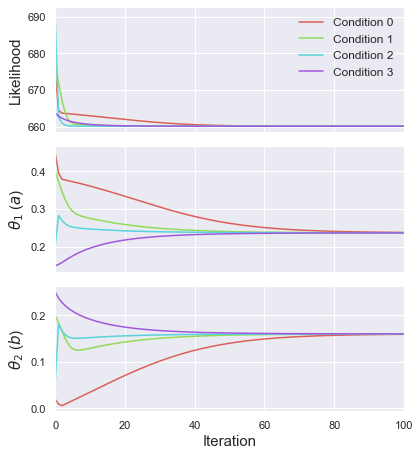

In [12]:
# We can plot the results, where we can see that the likelihood converges
# to a common value for all initial parameters, and the individual parameters
# \theta_1 (which is a) and \theta_2 (which is b), all converge to the same
# final value. This seems to indicate that out algorithm is working as expected
# and that the optimization is finding a local minimum,

fig, ax = plt.subplots(3, 1, figsize=(6, 6.5), sharex=True)
Pal = sns.color_palette('hls', len(l_res))
for i, (l, t) in enumerate(zip(l_res, theta_res)):
    ax[0].plot(l, color=Pal[i], label=f"Condition {i}")
    ax[1].plot([param[0] for param in t], color=Pal[i])
    ax[2].plot([param[1] for param in t], color=Pal[i])

ax[0].set_ylabel(r"Likelihood", fontsize=15)
ax[1].set_ylabel(r"$\theta_{1}$ ($a$)", fontsize=15)
ax[2].set_ylabel(r"$\theta_{2}$ ($b$)", fontsize=15)
ax[2].set_xlabel(r"Iteration", fontsize=15)

ax[0].legend(fontsize=12, frameon=False)
ax[0].set_xlim([0, 100])
plt.tight_layout()


In [13]:
# We can also, like in the previous notebook, detemine the likelihood function
# over the eitnre parameter space, so that we can visualize better the actual
# updates to the parameters, and how the move towards a minimum
def generate_likelihood_surface(
    obs_ts: Iterable[int], sample_dim: Optional[int] = 10
):
    est = infer.MarkovInfer(2, 2)

    a_vals = np.linspace(0.01, 0.99, sample_dim)
    b_vals = np.linspace(0.01, 0.99, sample_dim)

    likelihood = np.zeros((sample_dim, sample_dim))

    for i, a in enumerate(a_vals):
        A_sample = np.array([[1 - a, a], [a, 1 - a]])
        for j, b in enumerate(b_vals):
            B_sample = np.array([[1 - b, b], [b, 1 - b]])

            est.forward_algo(obs_ts, A_sample, B_sample, prediction_tracker=True)
            try:
                l = calc_likelihood(B_sample, est.predictions, obs_ts)
            except RuntimeWarning:
                l = None
            likelihood[i, j] = l

    return likelihood, a_vals, b_vals

# NOTE This cell takes a long time ~ 2.5 mins to run
likelihood_mat, aVals_arr, bVals_arr = generate_likelihood_surface(obs_ts, sample_dim=100)

In [14]:
# Format likelihood matrix into dataframe so that index coordinates are correctly mapped
import pandas as pd
df_lkly = pd.DataFrame(likelihood_mat)
df_lkly.columns = bVals_arr
df_lkly.index = aVals_arr
df_lkly.head()

,0.010000,0.019899,0.029798,0.039697,0.049596,0.059495,0.069394,0.079293,0.089192,0.099091,...,0.900909,0.910808,0.920707,0.930606,0.940505,0.950404,0.960303,0.970202,0.980101,0.990000
0.010000,1188.746912,1090.193085,1028.372201,983.327179,947.932522,918.869623,894.319081,873.162175,854.660272,838.303223,...,838.303223,854.660272,873.162175,894.319081,918.869623,947.932522,983.327179,1028.372201,1090.193085,1188.746912
0.019899,1103.893500,1020.375511,967.184808,927.908747,896.934826,871.512413,850.075138,831.649569,815.589916,801.444821,...,801.444821,815.589916,831.649569,850.075138,871.512413,896.934826,927.908747,967.184808,1020.375511,1103.893500
0.029798,1049.779908,974.574251,927.160021,892.028700,864.182934,841.266085,821.933700,805.335210,790.896984,778.213990,...,778.213990,790.896984,805.335210,821.933700,841.266085,864.182934,892.028700,927.160021,974.574251,1049.779908
0.039697,1009.373233,940.202732,896.886648,864.906901,839.545689,818.642244,800.992873,785.841819,772.677489,761.135737,...,761.135737,772.677489,785.841819,800.992873,818.642244,839.545689,864.906901,896.886648,940.202732,1009.373233
0.049596,976.498606,912.592971,872.504467,843.020219,819.686547,800.465040,784.237545,770.312044,758.223590,747.641584,...,747.641584,758.223590,770.312044,784.237545,800.465040,819.686547,843.020219,872.504467,912.592971,976.498606


Text(30.5, 0.5, 'b')

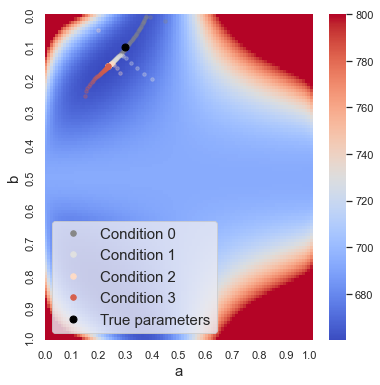

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

#Pal = sns.color_palette("Spectral", len(theta_tracker))
Pal = sns.color_palette('RdGy', 4)

alpha_map = np.linspace(0.2, 0.8, len(l_res[0]))

sns.heatmap(likelihood_mat.T, cmap='coolwarm', ax=ax, vmax=800)

for i, (l, t) in enumerate(zip(l_res, theta_res)):
    color =  Pal[i]
    for j, theta in enumerate(t):
        ax.plot([theta[0] * 100], [theta[1] * 100], 'o', markersize=3.5, color=Pal[3-i], alpha=0.3)
    ax.plot([theta[0] * 100], [theta[1] * 100], 'o', markersize=5.5, color=Pal[3-i], label=f"Condition {i}")

ax.plot(a * 100, b * 100, 'o', color='k', markersize=7, label="True parameters")
ax.legend(fontsize=15)

idx_arr = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]

ax.set_xticks(idx_arr)
ax.set_yticks(idx_arr)

ax.set_xticklabels(np.round(aVals_arr[idx_arr], 1))
ax.set_yticklabels(np.round(aVals_arr[idx_arr], 1))

ax.set_xlabel(r"a", fontsize=15)
ax.set_ylabel(r"b", fontsize=15)

So, here we can see that, the gradient descent algorithm is, in fact, able to locate the function minimum. In each case, the solution iterates down to the basin moving in the general $b = ma + c$ direction, and then moves along the bottom of that basin until convergence. Furthermore, the solutions all find the same final parameter vector, which is promising. However, this would not be the case when we initialized a parameter vector closer to the symmetric basin on the otehr side of $b=1/2$, or near $a=1, b=1/2$.  

Finally, one point of concern to watch is the non-monotonic behaviour of convergence in each solution. Ultimately, this is because the derivative of the likelihood near the boundaries of the domain gets very large, so even for small learning rates, this could lead to out-of-bounds behaviours, or unexpected numerical results in cases where we dont pay close attention. To remedy this, we could, for instance, introduce an adaptive learning rate that will be smaller when close to the boundaries, or, in a more extremem case, regularize the derivative terms so that we only really care about the direction of the update, and not its magnitude. 

Next, we turn to the infrastructure of `scipy.optimize` to let a more robust optimization algorithm(s) take on the heavy lifting, so that we can be more sure of its robustness, and test a larger variety of optimization techniques.

In [16]:
# As an alternate approach, we can use a built-in optimizer from scipy
import scipy.optimize

# however, to do that efficiently we need to redefine the objective function
def calc_likelihood_optimizer(
    param_arr: Iterable, obs_ts: Iterable, est: infer.MarkovInfer
) -> float:
    A, B = _build_hmm_parameters(param_arr)
    est.forward_algo(obs_ts, A, B, prediction_tracker=True)

    likelihood = 0
    for bayes, obs in zip(est.predictions, obs_ts):
        inner = bayes @ B[:, obs]
        likelihood -= np.log(inner)
    return likelihood

est = infer.MarkovInfer(2, 2)
# Initial parameters for optimization
param_init = [0.4, 0.4]
A, B = _build_hmm_parameters(param_init)
est.forward_algo(obs_ts, A, B, prediction_tracker=True)

# These are the bounds on the actual parameters themselves
bnds = ([0.001, 0.99], [0.001 ,0.99])

In testing these `scipy` optimizers, there are several different varieties, which you can read up on at this link: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

We will look primarily at the following:
- Sequential Least-SQuares Programming
- Truncated Newton
- Nelder-Mead (Quasi-Newton)
- Broyden-Fletcher-Goldfarb-Fano (BFGS) as well as its limited-memory counterpart
- Powell's Method

You can read up a little bit on each one, but they all have varying levels of accomodation for constraints and the need to internally calculate derivatives of the likelihood. For instance, the SLSQP algorithm is probably the most general purpose, and can accomodate constraints on the parameters that are equality or inequality. The other optimizers do not support constraints, but do allow for bounds. We dont really have a need
for constraints at the moment, but its always good to test in case we want to support constraints in the future. Alternatively, numerically evaluating function derivatives can be tricky, so Powell's method does not require that estimation. The BFGS algorithm is also a famous optimization algorithm because it effectively works at the order of a second derivative of the likelihood (calcualting the so-called Hessian matrix--or curvature--of the likelihood) but only everay actually computes first-order derivatives. 

In any case, feel free to dig into all of these methods, here we will simply show how to use them, and then the results that they get

In [18]:

# Sequential Least-Squares Progarmming (SLSQP) optimizer (that allows bounds)
def lkly_opt(method: str):
    return scipy.optimize.minimize(
        calc_likelihood_optimizer,
        param_init,
        args=(obs_ts, est),
        method=method,
        bounds=bnds
    )

# We cna use this syntax to calcualte the average run-time of each algorithm
%timeit lkly_opt("SLSQP")


393 ms ± 4.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:

# Nelder-Mead
%timeit lkly_opt('Nelder-Mead')

638 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
# This is the implementation of the Limited-Memory BFGS algorithm, that allows
# us to use bounds
%timeit lkly_opt('L-BFGS-B')


356 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%timeit lkly_opt('TNC')

2.53 s ± 29.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
# This algorithm throws warnings sometimes, so we best avoid it...
%timeit lkly_opt('Powell')


/var/folders/vt/d36dw3j55yxg5p19v5fbxm9r0000gn/T/ipykernel_87747/3416675954.py:14: RuntimeWarning: invalid value encountered in log
  likelihood -= np.log(inner)


769 ms ± 3.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
# If no method is selected, the algo automatically selects one of SLSQP,
# L-BFGS-B, or BFGS, depending on whether bounds or constraints are present,
# So if no bounds or contraints exist, then it will select BFGS, if there are
# bounds but no constraints, then it will use the L-BFGS-B algorithm, and if
# there are constraints the the SLSQP algorithm will be used
%timeit lkly_opt(None)

359 ms ± 4.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
# Now we can look at the actual result
res_slsqp = lkly_opt('SLSQP')
res_slsqp

     fun: 660.0909498123274
     jac: array([ 0.00382996, -0.0111618 ])
 message: 'Optimization terminated successfully'
    nfev: 40
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([0.23737704, 0.15941534])

In [28]:
res_nelder = lkly_opt('Nelder-Mead')
res_nelder

 final_simplex: (array([[0.23735236, 0.1594225 ],
       [0.23741108, 0.15941546],
       [0.23728326, 0.15948401]]), array([660.09094986, 660.09095069, 660.09095087]))
           fun: 660.0909498617091
       message: 'Optimization terminated successfully.'
          nfev: 66
           nit: 34
        status: 0
       success: True
             x: array([0.23735236, 0.1594225 ])

In [30]:
res_tnc = lkly_opt('TNC')
res_tnc

     fun: 660.1207122709917
     jac: array([-0.84419298, -7.14369435])
 message: 'Linear search failed'
    nfev: 255
     nit: 12
  status: 4
 success: False
       x: array([0.24576917, 0.1502341 ])

In [29]:
res_bfgs = lkly_opt('L-BFGS-B')
res_bfgs

      fun: 660.0909496554028
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00145519, -0.00200089])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 6
     njev: 12
   status: 0
  success: True
        x: array([0.23735407, 0.15943494])

So, from this it looks like the allowed optimizers are returning the correct results (insofar as they are consistent with one another), and they are equivalent to our own results from the gradient descent calcualtions.

Before finishing off, we will also look at one *global* optimizer, known as the Simplical Homology for Global Optimization (SHGO) algorithm, that is also implemented by `scipy`. You can look into the associated documentation about the optmization (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.shgo.html) if you want. The gist of it is that points are randomly sampled from the allawed domain of the parameters, and using repeated function evaluations, local and global minima can be found.  The upside of this algorithm is that we get all of the local minima in the parameter domain of interest, and so we can see whether or not we are only finding a local minimum through the usual likelihood methods.

In [31]:
# Finally, we can also look at global optimizer: Simplical Homology for Global Optimization (SHGO)
# To find the set of all local minima

def opt_shgo():
    return scipy.optimize.shgo(
        calc_likelihood_optimizer,
        bounds=bnds,
        args=(obs_ts, est),
        sampling_method='sobol'
    )

# This method takes a little longer, but is still relatively fast compared to
# our naive gradient descent algorithm
%timeit opt_shgo()


2.59 s ± 27.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
# And we can look at the results
res_shgo = opt_shgo()
res_shgo

     fun: 660.0909496542985
    funl: array([660.09094965, 660.09094965, 660.09094965, 693.14718056])
 message: 'Optimization terminated successfully.'
    nfev: 259
     nit: 2
   nlfev: 131
   nlhev: 0
   nljev: 34
 success: True
       x: array([0.23735414, 0.15943597])
      xl: array([[0.23735414, 0.15943597],
       [0.23735422, 0.15943591],
       [0.23735422, 0.84056405],
       [0.88192855, 0.5       ]])

Here we can see that there are two distinct minima (local) found by the global optimizer at a = 0.37 and b = 0.90, 0.10, which are degenerate global minima. In the earlier stages, when we start closest to the (0.37, 0.10) minima. Further, we can look at the run-times for a few algorithms, and find that (of those tested), the SLSQP algorithm has the fastest runtime, and the 'L-BFGS-B' has a comparable runtime. In any case, however, the runtime for the built-in optimizers is significantly improved upon the naive implementation of gradient descent.



In [37]:
# So, within the scope of the current package implementation, the way to run these optimizations from the infer module
# is through the following call
param_init = param_init_set[0]
est = infer.MarkovInfer(2, 2)

# This will use the LM-BFGS-B algorithm, and return a custom result type
res_loc = est.max_likelihood(param_init, obs_ts, mode='local')
# This will use the SHGO algorithm to perform the global optimization
res_glob = est.max_likelihood(param_init, obs_ts, mode='global')

In [38]:
# we can investigate the results:
res_loc

In [39]:
# Which has the attributes:
res_loc.__dict__

{'result': array([0.23735839, 0.15943457]),
 'type': 'local',
 'success': True,
 'likelihood': 660.0909496603282,
 'metadata': {'message': 'Optimization terminated successfully',
  'method': 'SLSQP'}}

In [41]:
# The result type is the same for the global optimizer, but there is an
# additional metadata information in the object
res_glob.__dict__

{'result': array([0.23735419, 0.84056407]),
 'type': 'global',
 'success': True,
 'likelihood': 660.0909496542989,
 'metadata': {'message': 'Optimization terminated successfully.',
  'sampling_method': 'sobol',
  'local_minima': array([[0.23735419, 0.84056407],
         [0.23735415, 0.15943594],
         [0.23735418, 0.15943595],
         [0.8153122 , 0.5       ]]),
  'local_likelihoods': array([660.09094965, 660.09094965, 660.09094965, 693.14718056])}}

So, to wrap up, this rather long tutorial notebook walked through the way to implement a gradient descent algorithm to perform a local
optimization of the likelihood function by calcualting the derivatives along various parameter dimensions. Using this, we were able to explicitly map out how the parameter vector was being updated in time. We then moved to use builtin optimization methods in the `scipy` library to speed things up and gain access to a more robust and accurate set of optimization routines. In the end we found through explicitly calling them, that (for our current scenario) the `L-BFGS-B` algorithm was fastest (while remaining accurate) and currently use this as the underlying default in the current package implementation.

Further, we looked at a global optimizer option (the `SHGO` algorithm) also within the `scipy` package, and found that it was also able to detect all local minima, which is a valuable feature in non-convex optimization problems.  Ultimately, the last few cells show how to call these optimizations from the package, and the results that would be expected from them.
